Description:  This script produces Figures 4,5, and 6 (plan view plots for lma gridded products like flash source density, flash footrpint, and flash initiation density overlaid with the identified ZDR column objects.)

In [1]:
import glob
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from skimage import io
import scipy.ndimage as ndimage
from skimage.measure import label, regionprops, regionprops_table

# load custom colormaps
from may19_2013_obs_analysis import cmap_extent_density_b13, cmap_footprint_b13


from may19_2013_obs_analysis.zdr_flash_panel_plots import zdr_col_bbox_facet
import matplotlib.colors as colors
# from may19_2013_obs_analysis.zdr_flash_panel_plots import plot_flash_zdr

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["xtick.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 25
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 2
plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams['axes.labelsize'] = 28

#### STEP 1: Object IDs of identified ZDR columns in our segmentation process

In [2]:
# after manual verification of all the ZDR column objects at the 4km level, we list out the ones that are embedded within Edmond-Carney storm
# This should filter out artifacts (due to gridding or contamination from nearby storms)
# each list within the obj_interest list specifies the object labels that are of our interest.
# There are 42 such lists in obj_interest corresponding to all the times for which we have gridded radar data

# DO NOT change this!

obj_interest = [
    [3],
    [2],
    [2],
    [1, 2],
    [3],
    [1],
    [2, 3],
    [2, 3, 4, 5],
    [5, 6],
    [2],
    [4, 5],
    [3, 4],
    [2, 3],
    [2, 3],
    [5, 6],
    [3],
    [4, 5],
    [3, 4],
    [3, 4],
    [1, 2],
    [3, 4],
    [6, 7, 9],
    [1, 2, 3],
    [3, 4, 5],
    [2, 3],
    [2, 3, 4, 5],
    [1, 2, 3],
    [1, 2],
    [2, 3],
    [2, 3],
    [1, 4],
    [1, 2],
    [1, 2],
    [2, 3],
    [1, 2],
    [3, 4, 5],
    [1],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
]

#### STEP 2: Next, we capture the coordinates and label of bounding boxes around zdr column objects

#### This way we can calculate the flash initiation density specifically within the region of zdr column objects

In [15]:
# Here we load the segmentation output files and get datetime objects for each time step from radar files

segmented_files = sorted(
    glob.glob("../data/processed/segmented_stacks/zdr/direct_array/*tiff")
)

# load KTLX level-II files (20:02:36 UTC to 22:57:25 UTC)
rad_files = sorted(glob.glob("path/to/KTLX_files/*V06"))
tmpstmps = [
    x.split("/")[-1][4:19] for x in rad_files
]  # access the time stamps from each radar file and convert those into datetime objects
dt_tmpstmps = [datetime.strptime(x, "%Y%m%d_%H%M%S") for x in tmpstmps]

In [4]:
# Here, we create a dataframe which stores the bbox region coordinates and label values for zdr column objects
# NOTE: These zdr column objects were identified from the segmentation result using direct array
# and not by reding files using the AICSImage reader.

segmented_files = sorted(
    glob.glob("../data/processed/segmented_stacks/zdr/direct_array/*.tiff")
)


final_zdr_df = pd.DataFrame()
for i in range(len(segmented_files)):

    cell_seg_reader = io.imread(segmented_files[i])
    cell_seg = cell_seg_reader
    seg = label(cell_seg)
    seg = np.fliplr(seg)

    # cell_seg = label(cell_seg[:,::-1,:])
    props = regionprops_table(seg, properties=["bbox", "bbox_area", "label"])

    df = pd.DataFrame(props)
    #     df.drop(labels=['time'],axis=1,inplace=True)

    df["time"] = dt_tmpstmps[i]
    df.index = df["time"]
    df.drop(labels=["time"], axis=1, inplace=True)

    df_sel = df[df["label"].isin(obj_interest[i])]
    # append zdr_col info df for current time step to the final_df
    final_zdr_df = final_zdr_df.append(df_sel,)

In [5]:
# include only the times of interest
from operator import itemgetter
segmented_files_final = itemgetter(6,7,8,9,10,11,17,18,19,26,27,30)(segmented_files)
dt_tmpstmps_final = itemgetter(6,7,8,9,10,11,17,18,19,26,27,30)(dt_tmpstmps)

#### STEP 3: Finally, we plot all our analysis in a nice looking figure with subplots

Before that, let's also load KTLX files to be used to overlay low-level reflectivity contours

In [6]:
# list out all gridded radar files (20:02:36 UTC to 22:57:25 UTC)
files_radar = sorted(glob.glob(os.path.expanduser("path/to/gridded_ktlx/*.nc")))

# select only the ones needed for Figure 7
files_rad_interest = list(
    itemgetter(6, 7, 8, 9, 10, 11, 17, 18, 19, 26, 27, 30)(files_radar)
)

In [7]:
rad_ds = xr.open_mfdataset(files_rad_interest,
    combine="nested",
    concat_dim="ntimes",
)

In [8]:
# llvl_data = rad_ds['reflectivity'].isel(z=4,time=0,ntimes=0).data
# smooth_data = ndimage.gaussian_filter(llvl_data, sigma=4)

Text(0.8, 0.55, 'N')

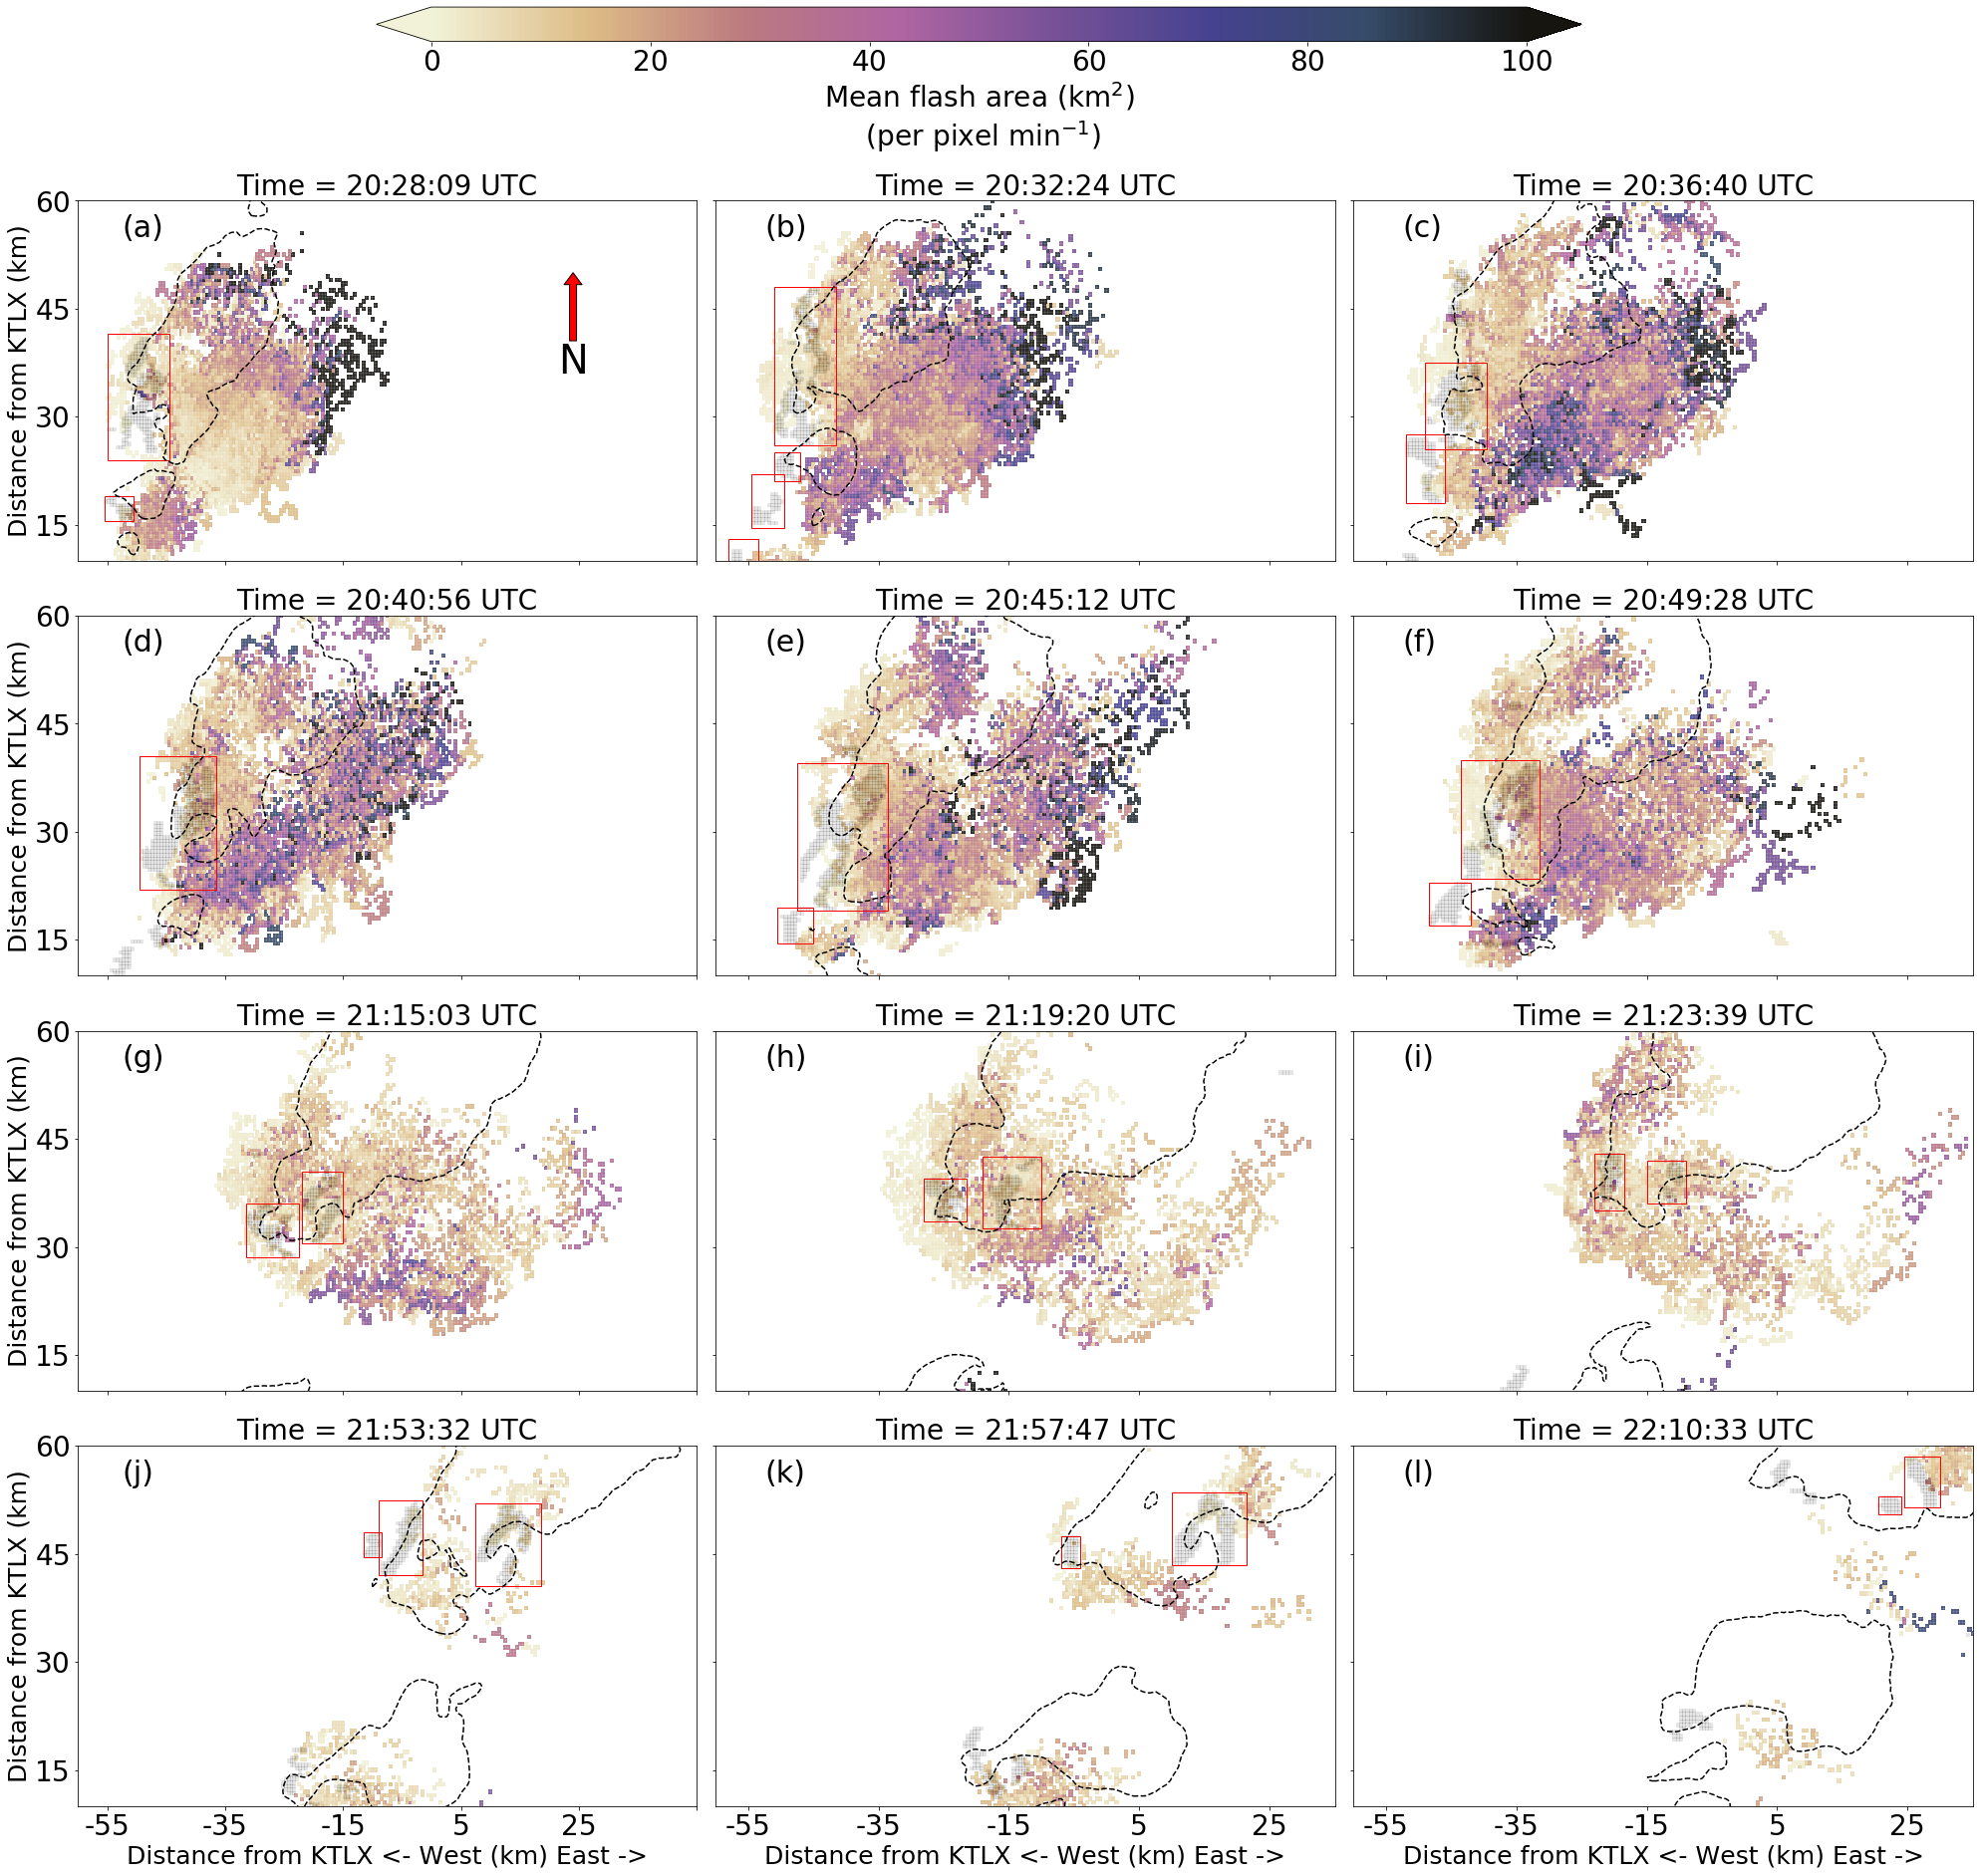

In [9]:
# This piece of code plots and overlays identified zdr column objects on top of flash footprint density
# We save these individual overlay plots to be able to create a gif stack later


ds = xr.open_mfdataset(
    "../data/processed/gridded_lma_files_2d_per_KTLX/*_footprint.nc",
    combine="nested",
    concat_dim="ntimes",
)
# rot_corrected_flash_foot = np.swapaxes(ds.flash_footprint, 1, 2)
rot_corrected_flash_foot = ds['flash_footprint'].where(ds['flash_footprint'] > 0).T
rot_corrected_flash_foot = rot_corrected_flash_foot.assign_coords({'ntimes':ds.time,
#                                                                    'lon':np.arange(-75,45.5,0.5),
#                                                                    'lat':np.arange(0,121,0.5)
                                                                  }
                                                                 )

p = rot_corrected_flash_foot.plot(col='ntimes',col_wrap=3,
                                  cmap='footprint_b13',alpha=1,
                                  aspect=1.5,size=6,
                                  add_colorbar=False,
                                  vmin=0,vmax=100,
                                  robust=True
#                                   cbar_kwargs={"orientation":"horizontal",
#                                                "shrink":0.8,
#                                                "aspect":40,
#                                                "pad":0.01,
#                                                "labelsize":20
#                                               },
                             )

cbaxes = p.fig.add_axes([0.2,1.07,0.6,0.02])
cbar = p.add_colorbar(cax=cbaxes,orientation='horizontal',extend='both',
               label='Mean flash area (km$^{2}$)\n (per pixel min$^{-1}$)',
               extendrect=False,)

labels = list(map(chr, range(97, 109)))

# We have to set axes limits for each subplot
for i in range(len(segmented_files_final)):
    gl = p.axes.flat[i]  #.gridlines(draw_labels=True,linestyle='--',alpha=0.5)
    gl.contour(rad_ds['reflectivity'].isel(z=4,time=i,ntimes=i).data,levels=[30],colors=['k'],linestyles=['--'])
    gl.top_labels = False
    gl.right_labels = False
    gl.ylines = False
    seg, rects,objs = zdr_col_bbox_facet(segmented_files_final[i],dt_tmpstmps_final[i],final_zdr_df)
    
    gl.pcolormesh(seg,cmap=colors.ListedColormap(['w','k','k','k','k','k','k','k','k']), alpha=0.1)
    
    for j in range(len(rects)):
        gl.add_patch(rects[j])
        
#         for k in range(len(objs)):
#             gl.annotate(
#                         objs[k]["label"][0],
#                         (objs[k]["bbox-5"][0], objs[k]["bbox-4"][0]),
#                         color="k",
#                         weight="bold",
#                         fontsize=25,
#                         ha="center",
#                         va="center",
#                     )
            
    gl.set_ylim(20,120)
    gl.set_xlim(30,220)
    gl.set_title(f"Time = {str(dt_tmpstmps_final[i]).split(' ')[-1]} UTC",fontsize=28)
    gl.text(45,110, f"({labels[i]})",fontsize=30)

for i in range(0,12,3):
    gl = p.axes.flat[i]
    gl.set_ylabel('Distance from KTLX (km)',fontsize=25)
    
    gl.set_xticks(np.arange(40,220+40,40))
    gl.set_xticklabels(['-55','-35','-15','5','25'])
    
    gl.set_yticks(np.arange(30,120+30,30))
    gl.set_yticklabels(['15','30','45','60'])

for i in range(9,12,1):
    gl = p.axes.flat[i]
    gl.set_xlabel('Distance from KTLX <- West (km) East ->',fontsize=25)

p.axes.flat[0].annotate('N', xy=(0.8, 0.8), xytext=(0.8, 0.55),
        arrowprops=dict(facecolor='red', width=7, headwidth=18),
        ha='center', va='center', fontsize=40,
        xycoords=p.axes.flat[0].transAxes)

#     gl.xlocator = ticker.FixedLocator([0, 10, 20, 50])
#     gl.ylocator = ticker.FixedLocator([0, 10, 20, 50])
    # gl.ylocator = LatitudeLocator()
#     gl.xformatter = LongitudeFormatter()
#     gl.yformatter = LatitudeFormatter()
#     gl.xlabel_style = {'size': 15, 'color': 'gray'}
#     gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

#     gl.ylabel_style = {'size': 15, 'color': 'gray'}
#     gl.ylabel_style = {'color': 'red', 'weight': 'bold'}

# plt.suptitle(f"z = {zs_level} m AGL",y=1.02)

# p.axes.flat[0].pcolormesh(seg[0, :, :], cmap="Greys", alpha=0.1)
# plt.savefig('/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/final_png_files/zdrobjectsflashfootprintpanel.png',dpi=300)

Text(0.8, 0.55, 'N')

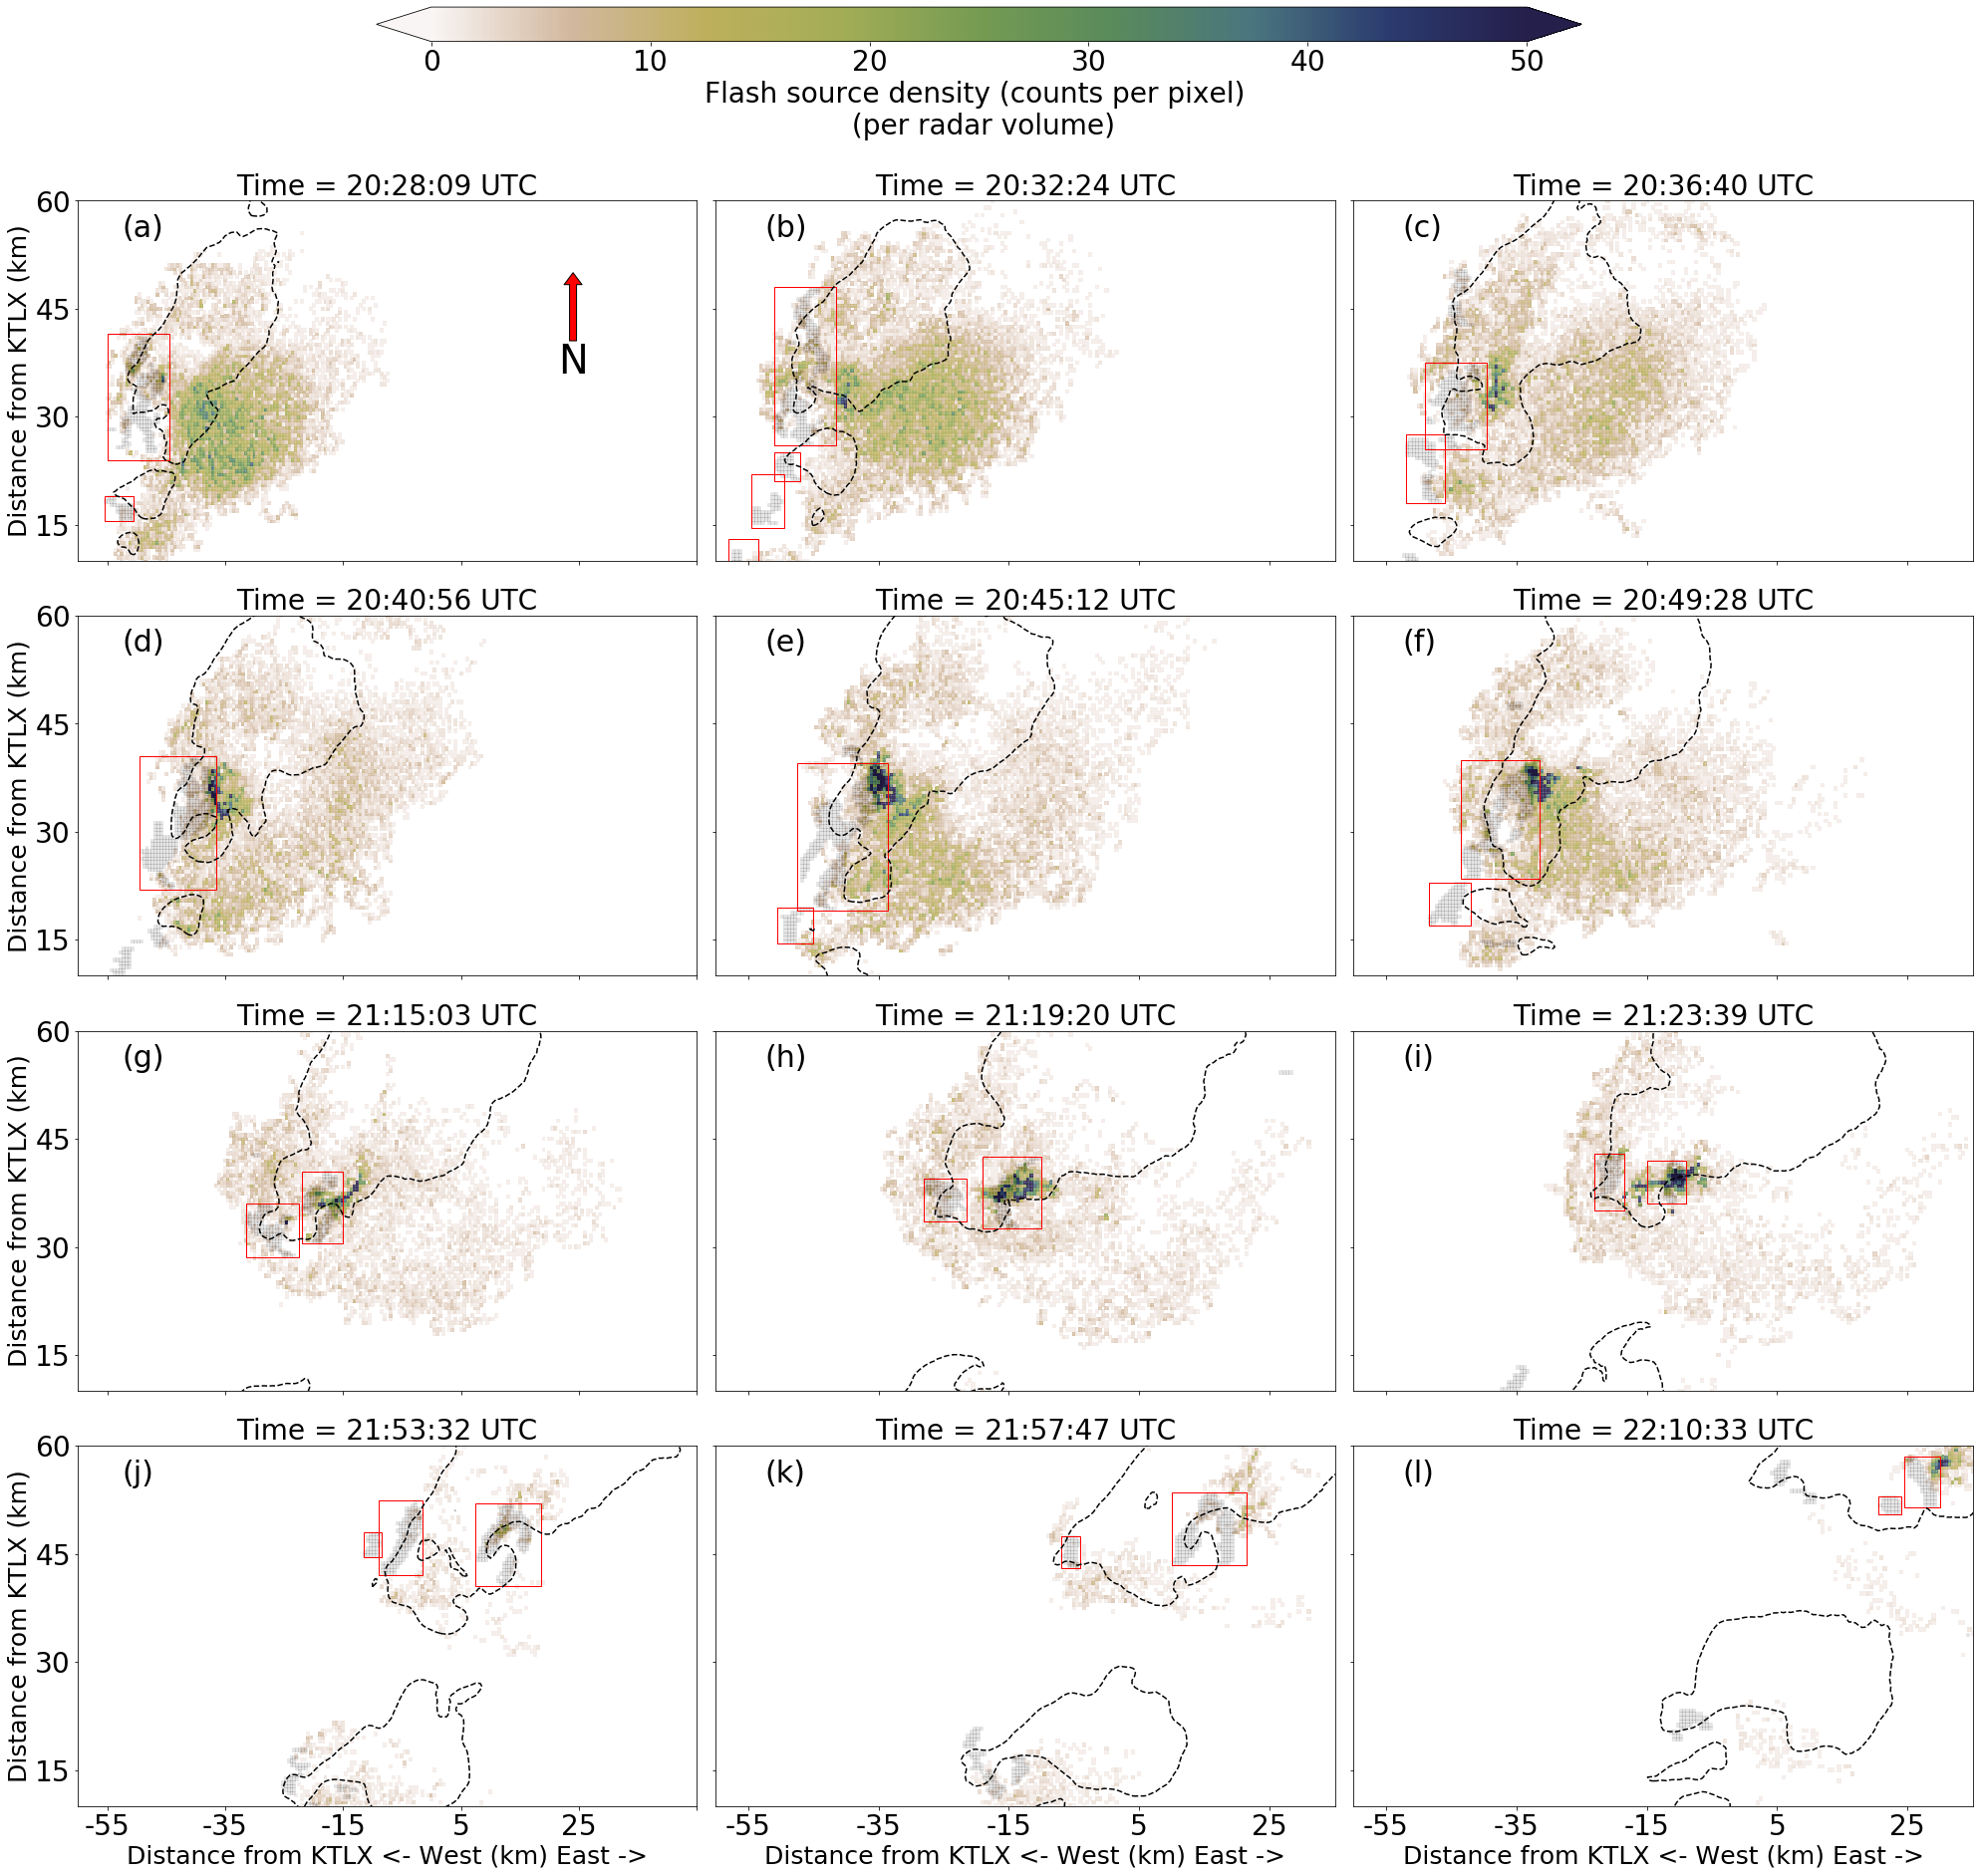

In [10]:
# This piece of code plots and overlays identified zdr column objects on top of flash source density

ds = xr.open_mfdataset(
    "../data/processed/gridded_lma_files_2d_per_KTLX/*_source.nc",
    combine="nested",
    concat_dim="ntimes",
)
rot_corrected_source = ds['lma_source'].where(ds['lma_source'] > 0).T
rot_corrected_source = rot_corrected_source.assign_coords({'ntimes':ds.time,
#                                                                    'lon':np.arange(-75,45.5,0.5),
#                                                                    'lat':np.arange(0,121,0.5)
                                                                  }
                                                                 )

p = rot_corrected_source.plot(col='ntimes',col_wrap=3,
                                  cmap='extent_density_b13_r',alpha=1,
                                  aspect=1.5,size=6,
                                  add_colorbar=False,
                                  vmin=0,vmax=50,
                                  robust=True
                                   )

cbaxes = p.fig.add_axes([0.2,1.07,0.6,0.02])
cbar = p.add_colorbar(cax=cbaxes,orientation='horizontal',extend='both',
               label='Flash source density (counts per pixel) \n (per radar volume)',
               extendrect=False,)

labels = list(map(chr, range(97, 109)))

# We have to set axes limits for each subplot
for i in range(len(segmented_files_final)):
    gl = p.axes.flat[i]  #.gridlines(draw_labels=True,linestyle='--',alpha=0.5)
    gl.contour(rad_ds['reflectivity'].isel(z=4,time=i,ntimes=i).data,levels=[30],colors=['k'],linestyles=['--'])
    gl.top_labels = False
    gl.right_labels = False
    gl.ylines = False
    seg, rects,objs = zdr_col_bbox_facet(segmented_files_final[i],dt_tmpstmps_final[i],final_zdr_df)
    
    gl.pcolormesh(seg,cmap=colors.ListedColormap(['w','k','k','k','k','k','k','k','k']), alpha=0.1)
    
    for j in range(len(rects)):
        gl.add_patch(rects[j])
            
    gl.set_xlim(30,220)
    gl.set_ylim(20,120)
    
    gl.set_title(f"Time = {str(dt_tmpstmps_final[i]).split(' ')[-1]} UTC",fontsize=28)
    gl.text(45,110, f"({labels[i]})",fontsize=30)

for i in range(0,12,3):
    gl = p.axes.flat[i]
    gl.set_ylabel('Distance from KTLX (km)',fontsize=25)
    
    gl.set_xticks(np.arange(40,220+40,40))
    gl.set_xticklabels(['-55','-35','-15','5','25'])
    
    gl.set_yticks(np.arange(30,120+30,30))
    gl.set_yticklabels(['15','30','45','60'])
    
for i in range(9,12,1):
    gl = p.axes.flat[i]
    gl.set_xlabel('Distance from KTLX <- West (km) East ->',fontsize=25)
    
p.axes.flat[0].annotate('N', xy=(0.8, 0.8), xytext=(0.8, 0.55),
        arrowprops=dict(facecolor='red', width=7, headwidth=18),
        ha='center', va='center', fontsize=40,
        xycoords=p.axes.flat[0].transAxes)

# plt.savefig('/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/final_png_files/zdrobjectsflashsrcdenpanel.png',dpi=300)

Text(0.8, 0.55, 'N')

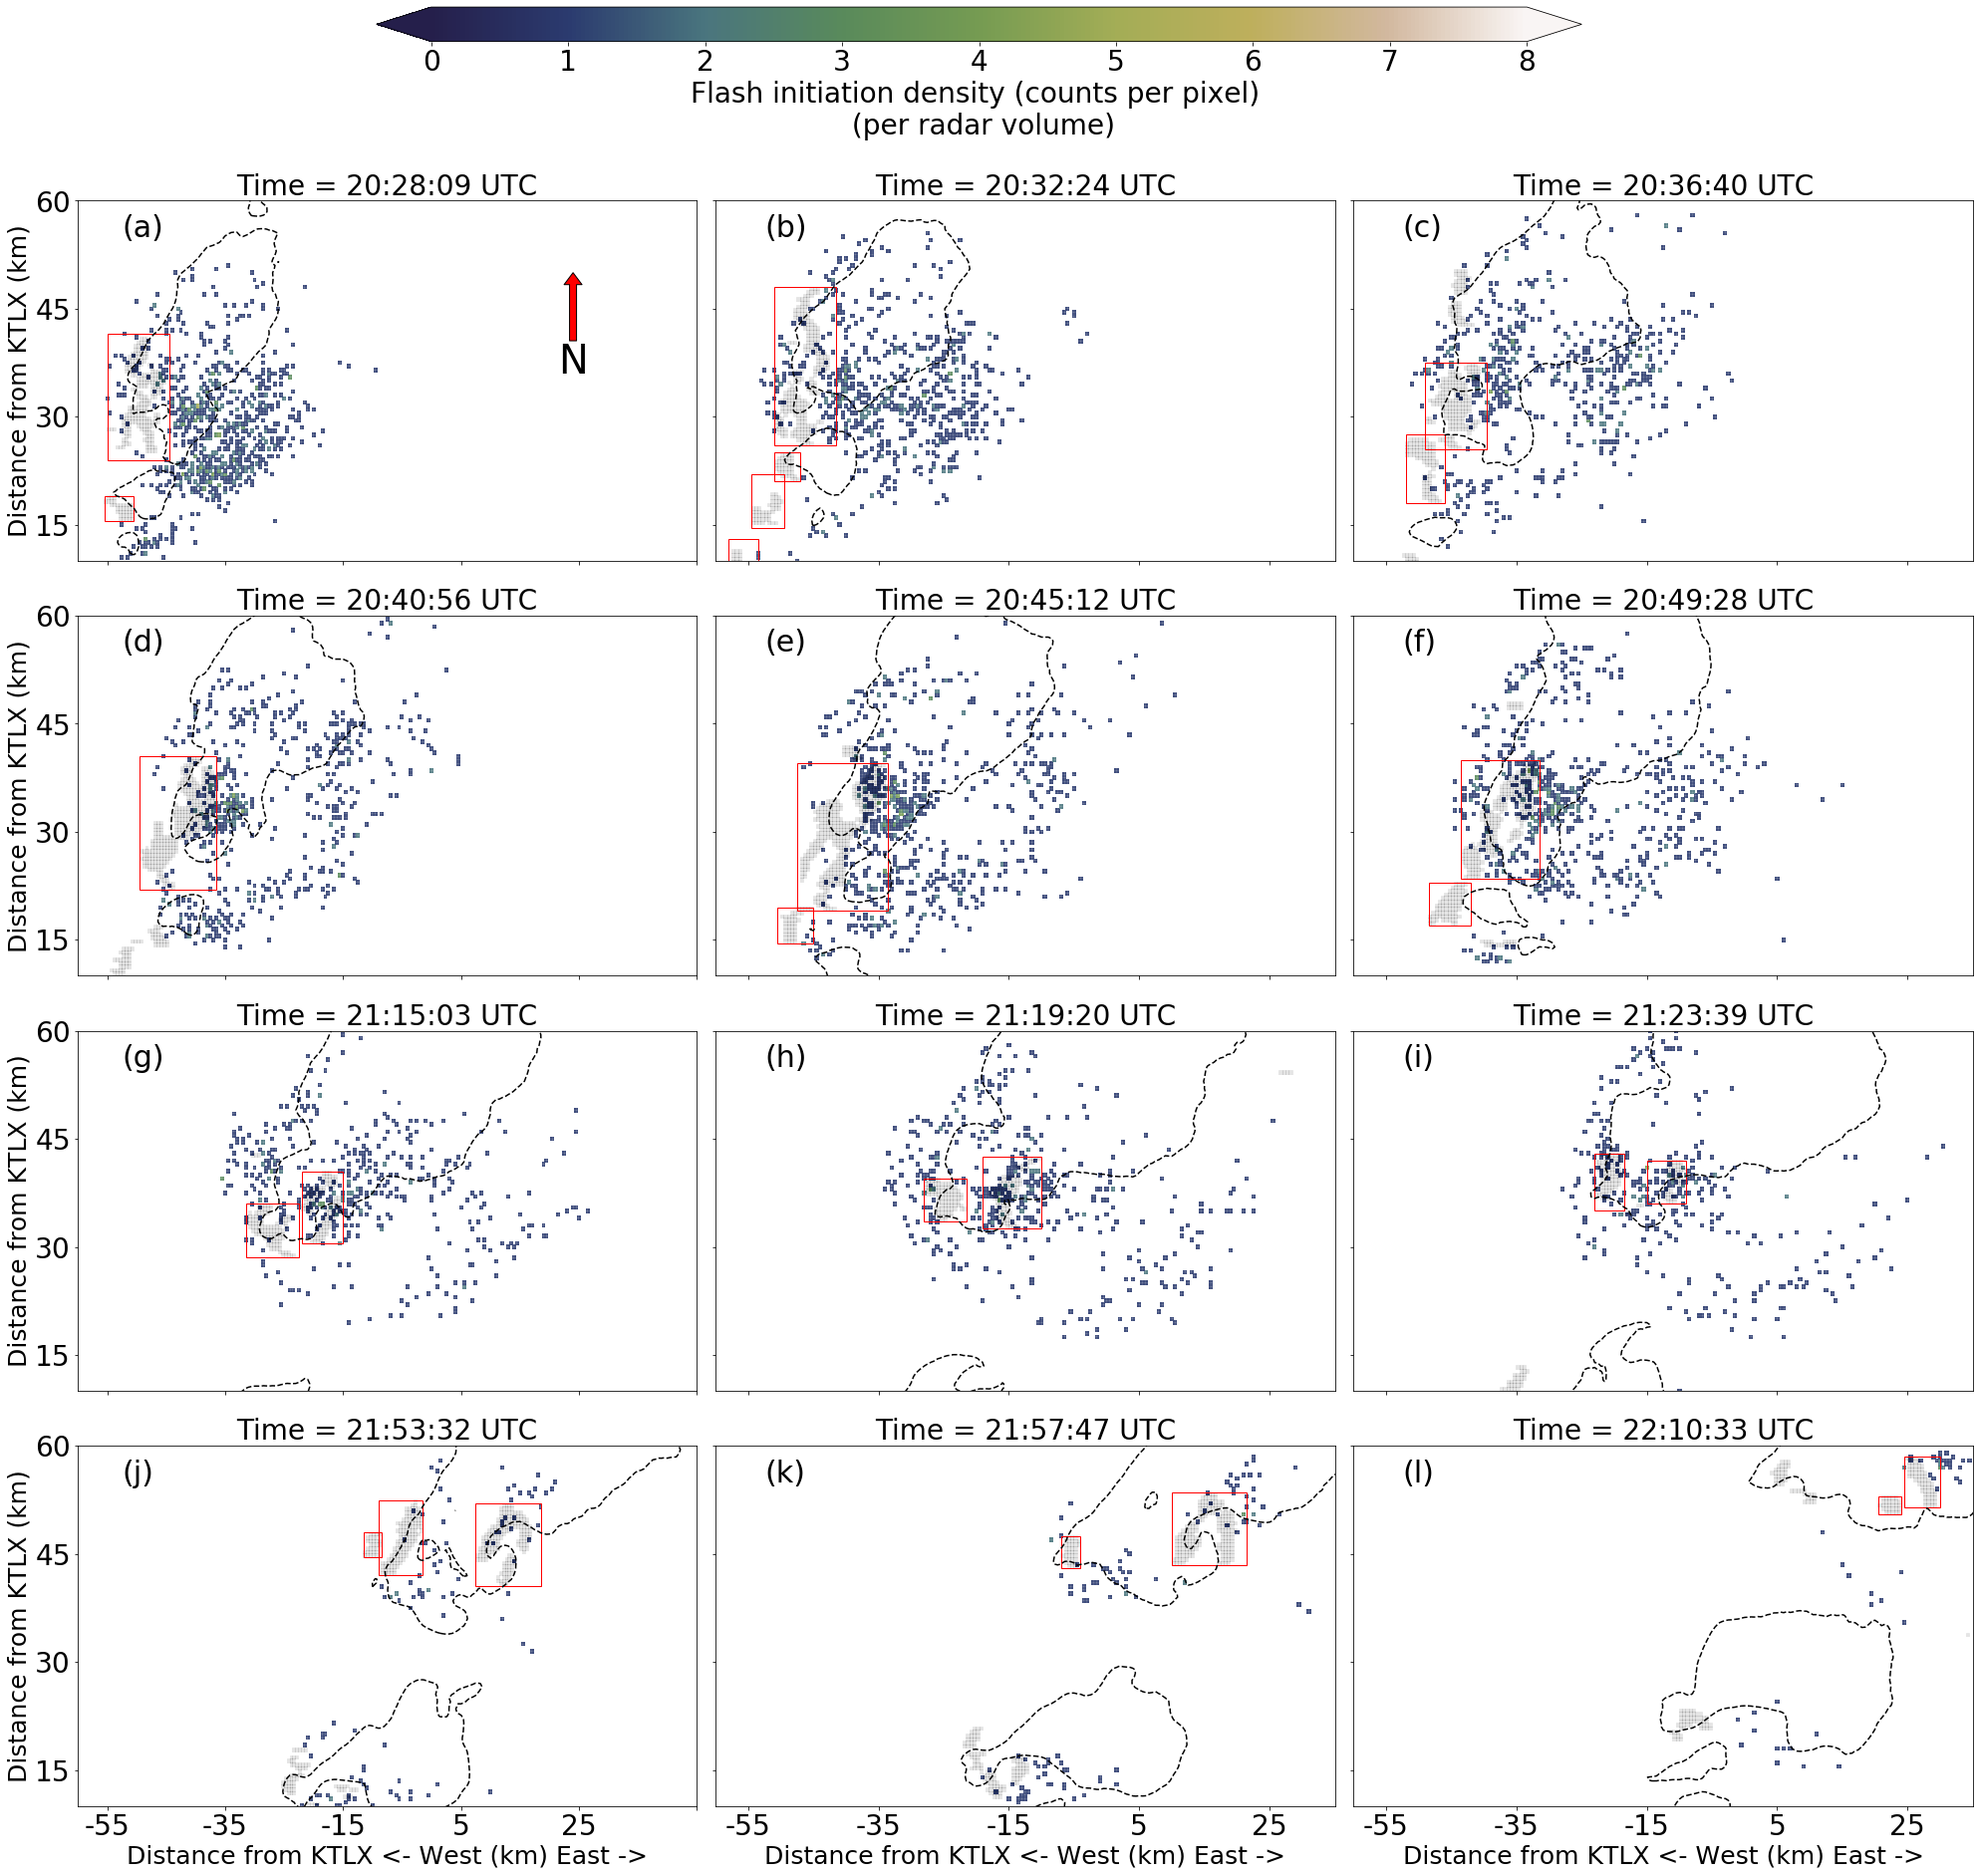

In [11]:
# This piece of code plots and overlays identified zdr column objects on top of flash initiation density

ds = xr.open_mfdataset(
    "../data/processed/gridded_lma_files_2d_per_KTLX/*_flash_init.nc",
    combine="nested",
    concat_dim="ntimes",
)
rot_corrected_init = ds['flash_initiation'].where(ds['flash_initiation'] > 0).T
rot_corrected_init = rot_corrected_init.assign_coords({'ntimes':ds.time})

p = rot_corrected_init.plot(col='ntimes',col_wrap=3,
                                  cmap='extent_density_b13',alpha=1,
                                  aspect=1.5,size=6,
                                  add_colorbar=False,
                                  vmin=0,vmax=8,
                                  robust=True
                                   )

cbaxes = p.fig.add_axes([0.2,1.07,0.6,0.02])
cbar = p.add_colorbar(cax=cbaxes,orientation='horizontal',extend='both',
               label='Flash initiation density (counts per pixel) \n (per radar volume)',
               extendrect=False,)

labels = list(map(chr, range(97, 109)))

# We have to set axes limits for each subplot
for i in range(len(segmented_files_final)):
    gl = p.axes.flat[i]  #.gridlines(draw_labels=True,linestyle='--',alpha=0.5)
    gl.contour(rad_ds['reflectivity'].isel(z=4,time=i,ntimes=i).data,levels=[30],colors=['k'],linestyles=['--'])
    gl.top_labels = False
    gl.right_labels = False
    gl.ylines = False
    seg, rects,objs = zdr_col_bbox_facet(segmented_files_final[i],dt_tmpstmps_final[i],final_zdr_df)
    
    gl.pcolormesh(seg,cmap=colors.ListedColormap(['w','k','k','k','k','k','k','k','k']), alpha=0.1)
    
    for j in range(len(rects)):
        gl.add_patch(rects[j])
            
    gl.set_xlim(30,220)
    gl.set_ylim(20,120)
    
    gl.set_title(f"Time = {str(dt_tmpstmps_final[i]).split(' ')[-1]} UTC",fontsize=28)
    gl.text(45,110, f"({labels[i]})",fontsize=30)

for i in range(0,12,3):
    gl = p.axes.flat[i]
    gl.set_ylabel('Distance from KTLX (km)',fontsize=25)
    
    gl.set_xticks(np.arange(40,220+40,40))
    gl.set_xticklabels(['-55','-35','-15','5','25'])
    
    gl.set_yticks(np.arange(30,120+30,30))
    gl.set_yticklabels(['15','30','45','60'])
    
for i in range(9,12,1):
    gl = p.axes.flat[i]
    gl.set_xlabel('Distance from KTLX <- West (km) East ->',fontsize=25)

p.axes.flat[0].annotate('N', xy=(0.8, 0.8), xytext=(0.8, 0.55),
        arrowprops=dict(facecolor='red', width=7, headwidth=18),
        ha='center', va='center', fontsize=40,
        xycoords=p.axes.flat[0].transAxes)

# plt.savefig('/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/final_png_files/zdrobjectsflashinitiationpanel.png',dpi=300)